# Samuel Davidson
---
## Tree identification using maching learning
---
A quick example of image classification


### Sources
1. https://keras.io/api/preprocessing/image/
2. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?version=nightly
3. https://keras.io/examples/vision/image_classification_from_scratch/
4. https://edusecrets.com/lesson-02-creating-a-file-select-button-in-jupyter-notebook/

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import tensorflow as tf
from ipywidgets import *
from IPython.display import clear_output, display
from tkinter import Tk, filedialog

In [2]:
image_size = (32, 32)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/TREES/TRAIN',
    # validation_split=0.2,
    # subset='training',
    labels='inferred',
    label_mode='categorical',
    seed=1000,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/TREES/TEST',
    # validation_split=0.2,
    # subset='validation',
    labels='inferred',
    label_mode='categorical',
    seed=1000,
    image_size=image_size,
    batch_size=batch_size
)



Found 2500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


In [3]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

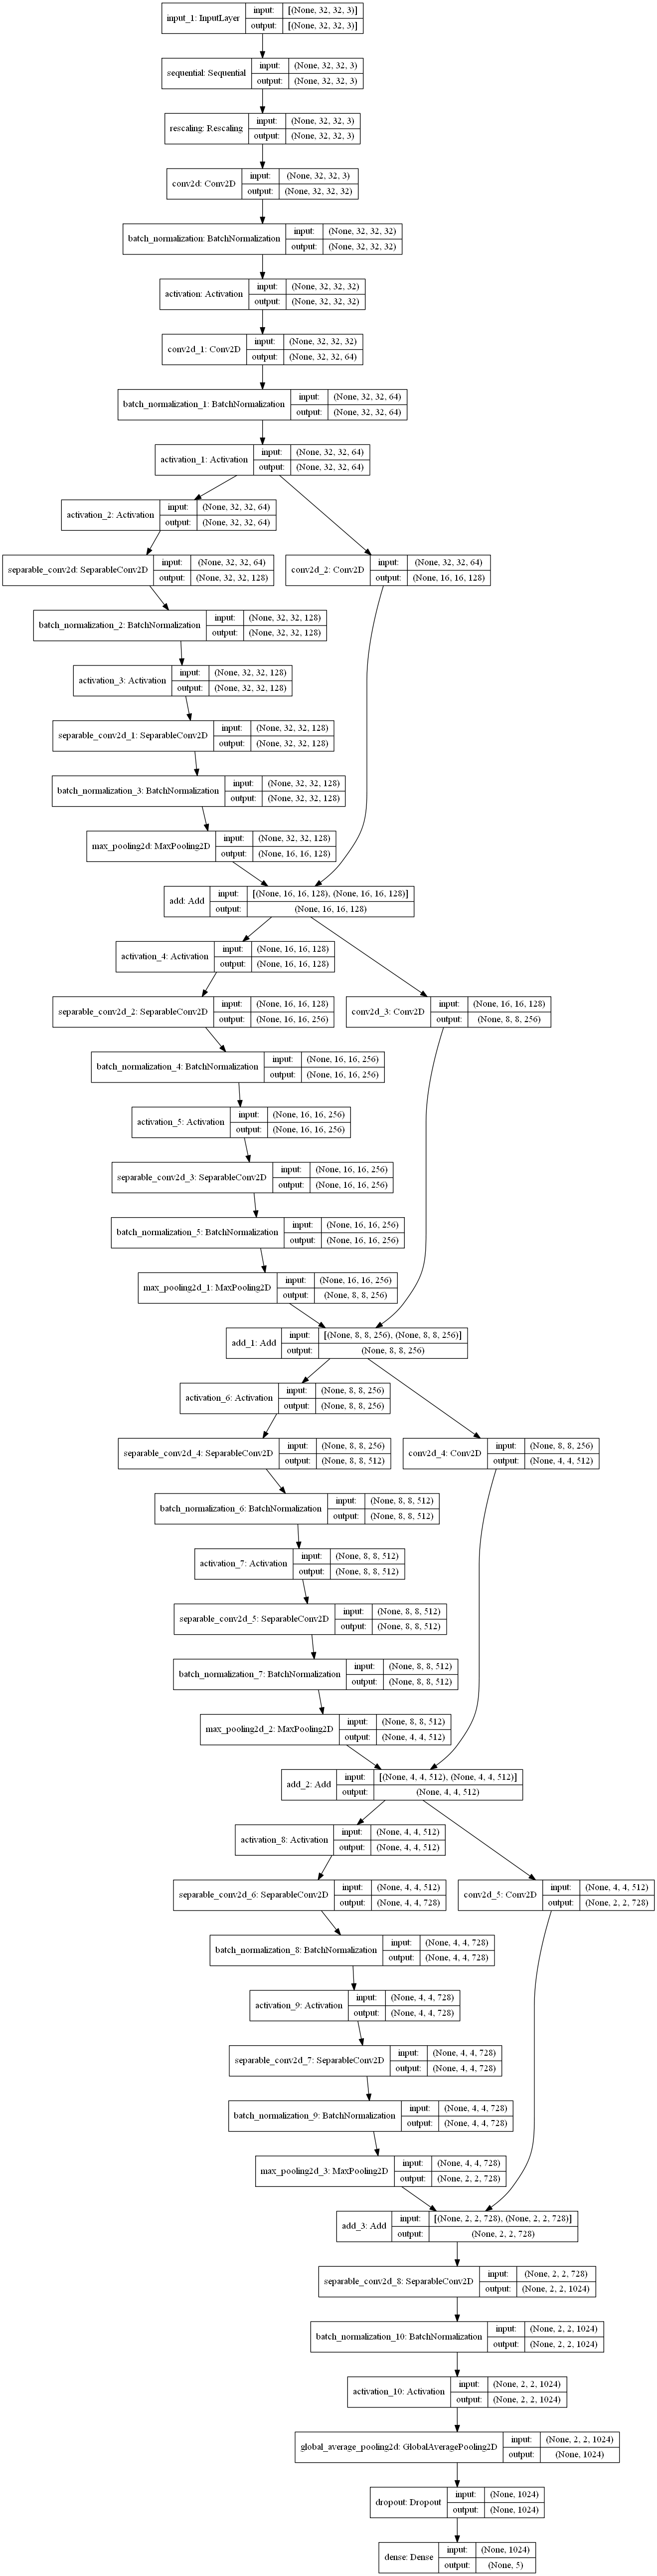

In [4]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # image aughmentation block
    x = data_augmentation(inputs)

    #entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

In [9]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint('H5/save_at_{epoch}.h5'),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='CategoricalCrossentropy',
    metrics=['accuracy'],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
79/79 [==============================] - 24s 287ms/step - loss: 0.9793 - accuracy: 0.6256 - val_loss: 1.0914 - val_accuracy: 0.5820
Epoch 2/50
79/79 [==============================] - 22s 283ms/step - loss: 0.9210 - accuracy: 0.6504 - val_loss: 1.1883 - val_accuracy: 0.6000
Epoch 3/50
79/79 [==============================] - 22s 283ms/step - loss: 0.8881 - accuracy: 0.6616 - val_loss: 1.0671 - val_accuracy: 0.6160
Epoch 4/50
79/79 [==============================] - 23s 284ms/step - loss: 0.8664 - accuracy: 0.6660 - val_loss: 1.0658 - val_accuracy: 0.6140
Epoch 5/50
79/79 [==============================] - 22s 284ms/step - loss: 0.8337 - accuracy: 0.6820 - val_loss: 1.4752 - val_accuracy: 0.5220
Epoch 6/50
79/79 [==============================] - 23s 286ms/step - loss: 0.8377 - accuracy: 0.6772 - val_loss: 0.9879 - val_accuracy: 0.6600
Epoch 7/50
79/79 [==============================] - 22s 284ms/step - loss: 0.8334 - accuracy: 0.6960 - val_loss: 1.1390 - val_accuracy: 0.6060

E:/Cloud Storage/Dropbox/Spring 2021/Data Modeling/Finals/Final Project/data/TREES/TEST/pine_tree/pine_s_000258.png
[2.8545491e-03 2.1936263e-01 6.0708140e-07 7.7703214e-01 7.5010647e-04]
This image is 0.78 percent a Pine Tree


Button(description='Select File', style=ButtonStyle())

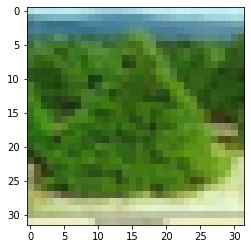

In [10]:
def prompt_select():
    fileselect = Button(description="Select File")
    fileselect.on_click(file_selected)
    display(fileselect)

def test_img(img_url):
    img = keras.preprocessing.image.load_img(
        img_url, target_size=image_size
    )
    
    plt.imshow(img)
    
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)

    iterations = 0
    tree = 0
    percent = 0
    label = ['Maple', 'Oak', 'Palm', 'Pine', 'Willow']

    print(predictions[0])

    for prediction in predictions[0]:
        if prediction > percent:
            tree = iterations
            percent = prediction
        iterations += 1

    print(
        "This image is {:.2f} percent a {lab} Tree".format(percent, lab = label[tree])
        )
    
    prompt_select()

def file_selected(b):
    clear_output()
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    b.files = filedialog.askopenfilename(multiple=False)
    print(b.files)
    test_img(b.files)

prompt_select()